# Fast Dequantizatoin

How to enbale fast dequantization (INT4/2/1 -> FP16/INT8) or (FP8 -> FP16)?

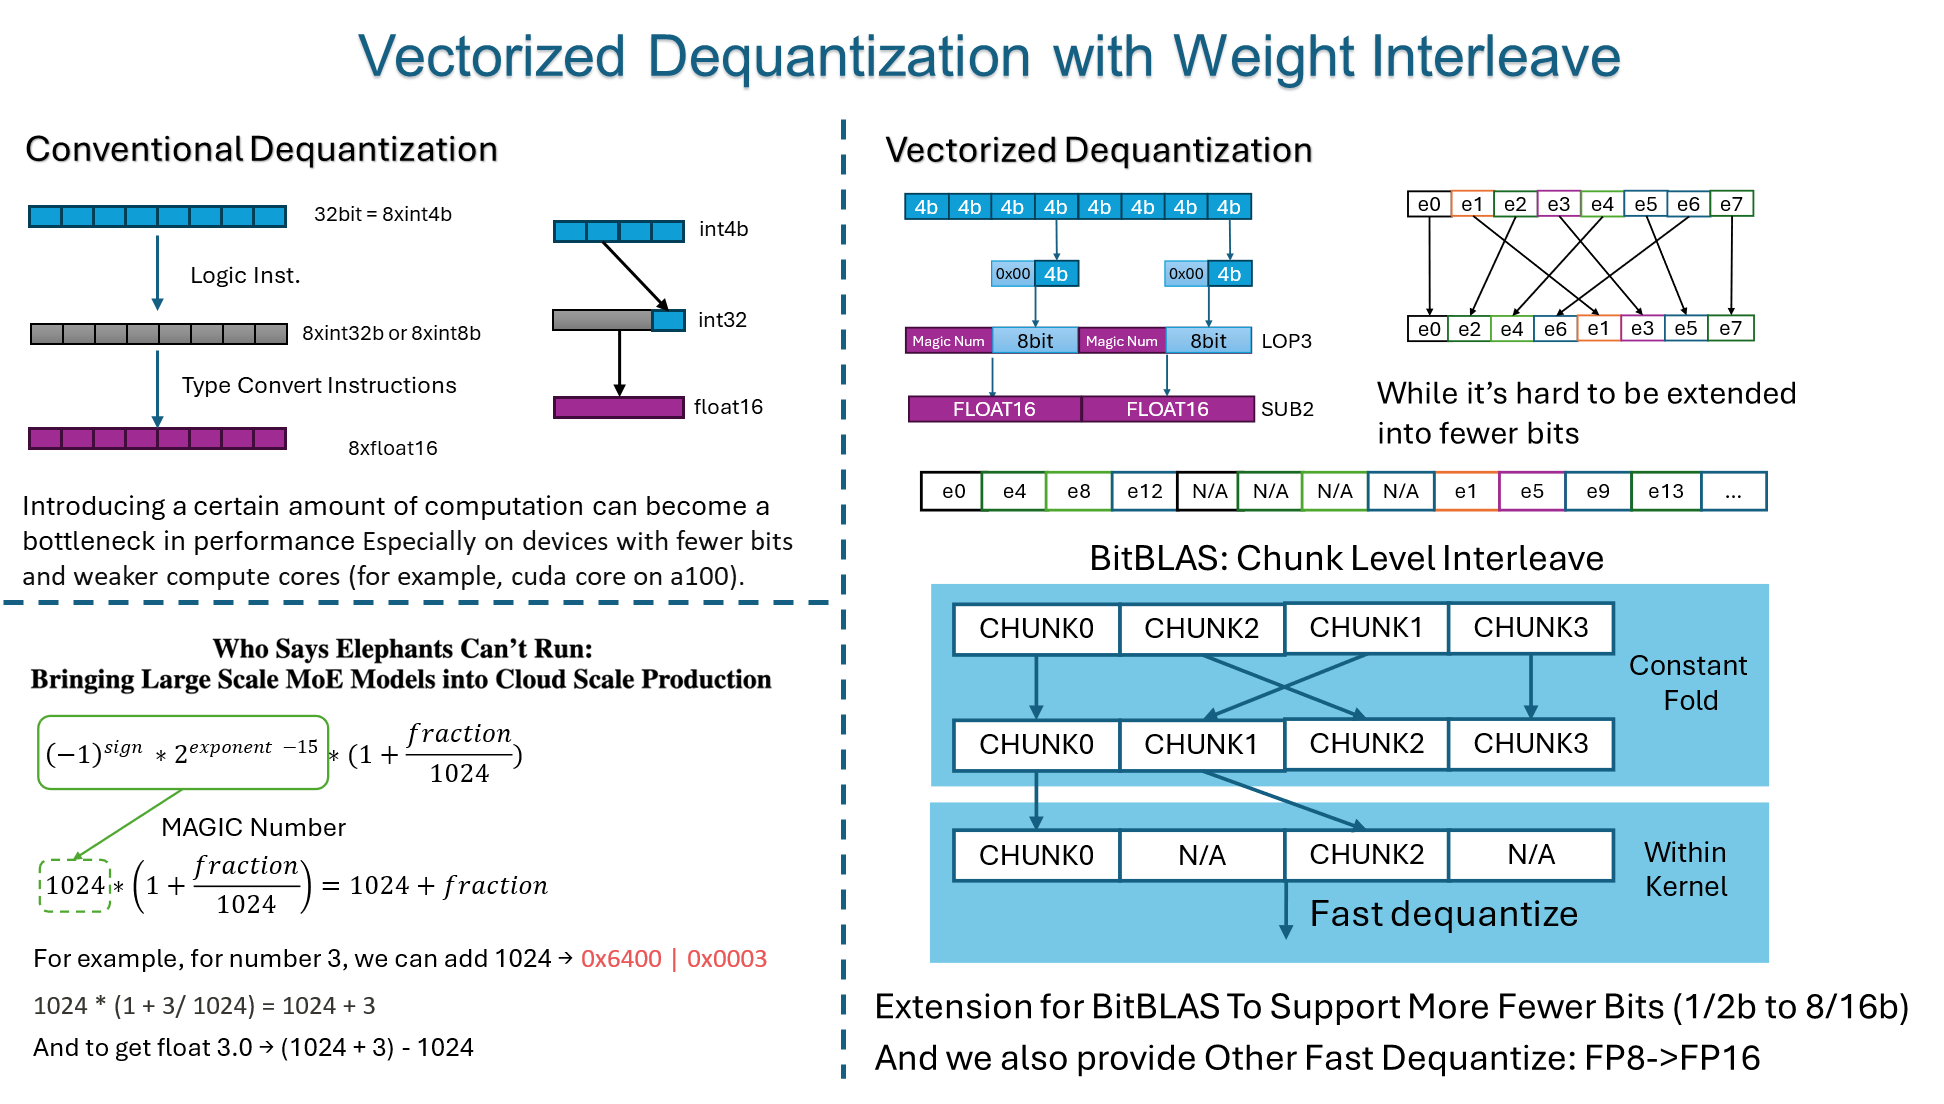

In [1]:
import bitblas
import torch

# enabling debug output

bitblas.set_log_level("Debug")
matmul_config = bitblas.MatmulConfig(
    M=1,  # M dimension
    N=1024,  # N dimension
    K=1024,  # K dimension
    A_dtype="float16",  # activation A dtype
    W_dtype="int4",  # weight W dtype
    accum_dtype="float16",  # accumulation dtype
    out_dtype="float16",  # output dtype
    layout="nt",  # matrix layout, "nt" indicates the layout of A is non-transpose and the layout of W is transpose
    with_bias=False,  # bias
    # configs for weight only quantization
    group_size=None,  # setting for grouped quantization
    with_scaling=False,  # setting for scaling factor
    with_zeros=False,  # setting for zeros
    zeros_mode=None,  # setting for how to calculating zeros
)

matmul = bitblas.Matmul(config=matmul_config)

# Create input matrices
input_tensor = torch.rand((1, 1024), dtype=torch.float16).cuda()
weight_tensor = torch.randint(0, 7, (1024, 1024), dtype=torch.int8).cuda()

# Transform weight tensor to int4 data type
weight_tensor_int4 = matmul.transform_weight(weight_tensor)

# Perform mixed-precision matrix multiplication
output_tensor = matmul(input_tensor, weight_tensor_int4)

# Reference result using PyTorch matmul for comparison
ref_result = torch.matmul(input_tensor, weight_tensor.t().to(torch.float16))
# Assert that the results are close within a specified tolerance, note that the int4 randint value is a little bigger than the float16 value, so we set the atol to 1.0
print("Ref output:", ref_result)
print("BitBLAS output:", output_tensor)
torch.testing.assert_close(output_tensor, ref_result, rtol=1e-2, atol=1e-0)

2024-10-24 14:35:48 [BitBLAS:INFO]: Auto detected target: nvidia/geforce-rtx-4090
2024-10-24 14:35:49 [BitBLAS:DEBUG]: Cannot find the appropriate index map for tensorcore
2024-10-24 14:36:16 [BitBLAS:DEBUG]: Cannot find the appropriate index map for tensorcore
2024-10-24 14:36:16 [BitBLAS:DEBUG]: Apply config {'block': [2], 'thread': [2], 'rstep': [1024], 'reduce_thread': [64], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-24 14:36:16 [BitBLAS:DEBUG]: Apply config {'block': [1], 'thread': [1], 'rstep': [1024], 'reduce_thread': [128], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-24 14:36:16 [BitBLAS:DEBUG]: Apply config {'block': [4], 'thread': [4], 'rstep': [1024], 'reduce_thread': [32], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-24 14:36:16 [BitBLAS:DEBUG]: Apply config {'block': [8], 'thread': [8], 'rstep': [1024], 'reduce_thread': [16], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-24 14:36:16 [BitBLAS:DEBUG]: Apply config {'block': [16], 'thread': [16], 'rstep': [512], 'reduce

In [ ]:
import bitblas
import torch

# enabling debug output
bitblas.set_log_level("Debug")
matmul_config = bitblas.MatmulConfig(
    M=1,  # M dimension
    N=16384,  # N dimension
    K=16384,  # K dimension
    A_dtype="float16",  # activation A dtype
    W_dtype="float16",  # weight W dtype
)

matmul = bitblas.Matmul(config=matmul_config, enable_tuning=False)

matmul.hardware_aware_finetune(topk=20, parallel_build=True)

latency = matmul.profile_latency()
print(f"{latency=}")

In [ ]:
matmul_config = bitblas.MatmulConfig(
    M=1,  # M dimension
    N=16384,  # N dimension
    K=16384,  # K dimension
    A_dtype="float16",  # activation A dtype
    W_dtype="int4",  # weight W dtype
    fast_decoding=False, # Disable Fast Decoding
)

matmul = bitblas.Matmul(config=matmul_config, enable_tuning=False)

matmul.hardware_aware_finetune(topk=20, parallel_build=True)

print(matmul.get_source())

2024-10-24 14:45:08 [BitBLAS:INFO]: Auto detected target: nvidia/geforce-rtx-4090
2024-10-24 14:45:08 [BitBLAS:DEBUG]: Cannot find the appropriate index map for tensorcore
2024-10-24 14:45:10 [BitBLAS:DEBUG]: Cannot find the appropriate index map for tensorcore
2024-10-24 14:45:11 [BitBLAS:DEBUG]: Apply config {'block': [32], 'thread': [32], 'rstep': [256], 'reduce_thread': [4], 'vectorize': {'A': 2, 'B_decode': 8}}
2024-10-24 14:45:11 [BitBLAS:DEBUG]: Apply config {'block': [16], 'thread': [16], 'rstep': [512], 'reduce_thread': [8], 'vectorize': {'A': 4, 'B_decode': 8}}
2024-10-24 14:45:11 [BitBLAS:DEBUG]: Apply config {'block': [8], 'thread': [8], 'rstep': [1024], 'reduce_thread': [16], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-24 14:45:11 [BitBLAS:DEBUG]: Apply config {'block': [4], 'thread': [4], 'rstep': [2048], 'reduce_thread': [32], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-24 14:45:11 [BitBLAS:DEBUG]: Apply config {'block': [2], 'thread': [2], 'rstep': [4096], 'reduce_t

In [3]:
latency = matmul.profile_latency()
print(f"{latency=}")

latency=0.1433375


In [4]:
matmul_config = bitblas.MatmulConfig(
    M=1,  # M dimension
    N=16384,  # N dimension
    K=16384,  # K dimension
    A_dtype="float16",  # activation A dtype
    W_dtype="int4",  # weight W dtype
    fast_decoding=True, # Disable Fast Decoding
)


matmul = bitblas.Matmul(config=matmul_config, enable_tuning=False)

matmul.hardware_aware_finetune(topk=20, parallel_build=True)

print(matmul.get_source())
latency = matmul.profile_latency()
print(f"{latency=}")

2024-10-24 14:44:22 [BitBLAS:INFO]: Auto detected target: nvidia/geforce-rtx-4090
2024-10-24 14:44:22 [BitBLAS:DEBUG]: Cannot find the appropriate index map for tensorcore
2024-10-24 14:44:25 [BitBLAS:DEBUG]: Cannot find the appropriate index map for tensorcore
2024-10-24 14:44:25 [BitBLAS:DEBUG]: Apply config {'block': [32], 'thread': [32], 'rstep': [256], 'reduce_thread': [4], 'vectorize': {'A': 2, 'B_decode': 8}}
2024-10-24 14:44:25 [BitBLAS:DEBUG]: Apply config {'block': [16], 'thread': [16], 'rstep': [512], 'reduce_thread': [8], 'vectorize': {'A': 4, 'B_decode': 8}}
2024-10-24 14:44:25 [BitBLAS:DEBUG]: Apply config {'block': [8], 'thread': [8], 'rstep': [1024], 'reduce_thread': [16], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-24 14:44:25 [BitBLAS:DEBUG]: Apply config {'block': [4], 'thread': [4], 'rstep': [2048], 'reduce_thread': [32], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-24 14:44:25 [BitBLAS:DEBUG]: Apply config {'block': [2], 'thread': [2], 'rstep': [4096], 'reduce_t

## Performance of Fast Dequantization on A100-80G

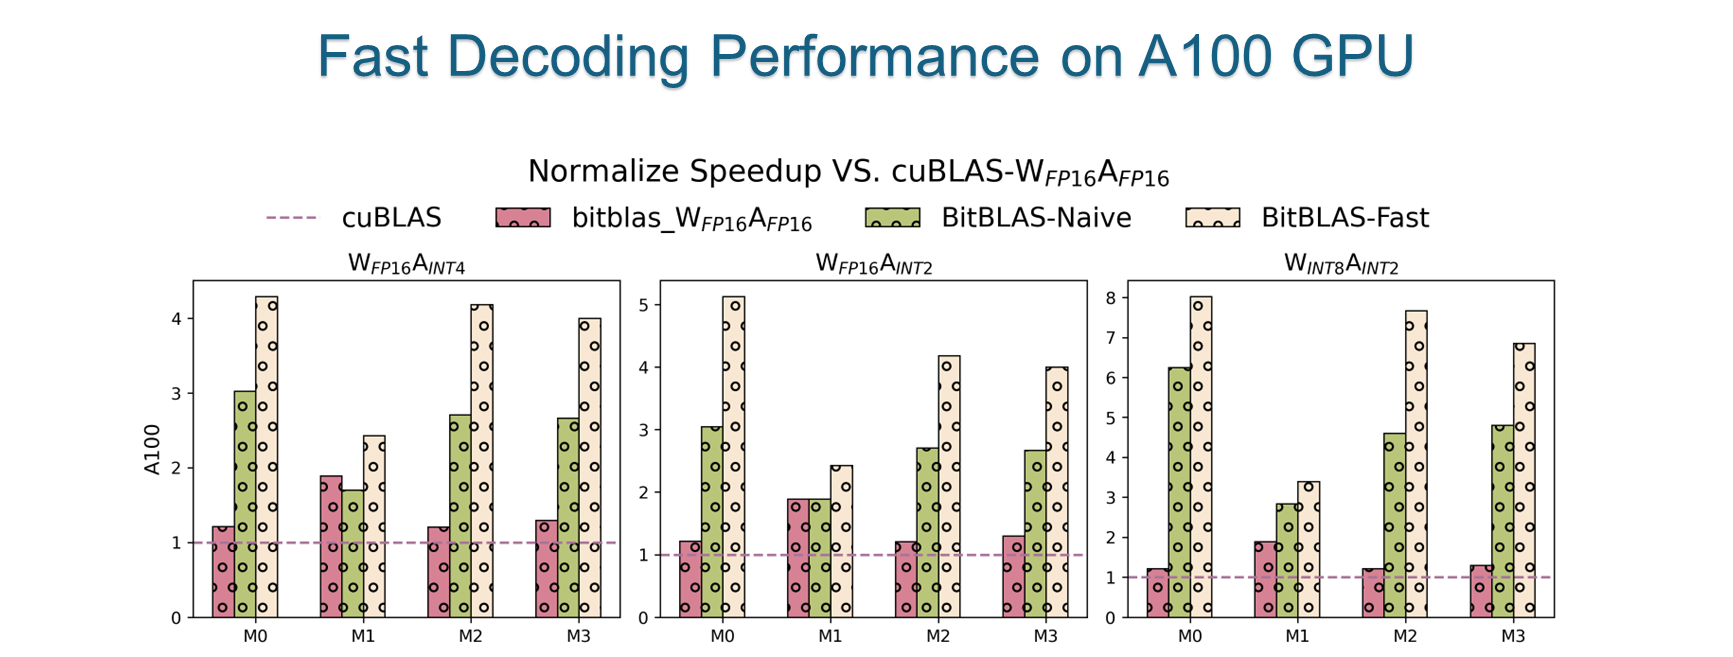